In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import yaml
import random
%matplotlib inline
sns.set_style('whitegrid')
torch.manual_seed(42)
random.seed(42)

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

# Initialization

Set paths and names of the pre-trained models.

In [3]:
path_base = '../saved_models/covid_selected/icml/'

path_poe_10x = path_base + 'poe_10xWeights/'
path_cc_10x = path_base + 'cc_10xWeights/'

path_poe_balanced = path_base + 'poe_balanced/'
path_cc_balanced = path_base + 'cc_balanced/'

path_sgTr = path_base + 'tcr/'
path_sgRNA = path_base + 'rna/'

name_poe_10x = 'covid_tune_joint_transformer_poe_best_rec_model.pt'
name_cc_10x = 'covid_tune_joint_transformer_separate_best_rec_model.pt'

name_poe_balanced = 'covid_tune_joint_transformer_poe_best_rec_model.pt'
name_cc_balanced = 'covid_tune_joint_transformer_separate_best_rec_model.pt'

name_sgTr = 'covid_tune_single_transformer_separate_best_rec_model.pt'
name_sgRNA = 'covid_tune_single_scRNA_best_rec_model.pt'

# Load models

The following methods load and restore the weights of the pre-trained models used during publication.

In [4]:
def correct_params(params):
    params['loss_weights'] = [params['loss_weights_scRNA'], params['loss_weights_seq'], params['loss_weights_kl']]
    params['shared_hidden'] = [params['shared_hidden']]
    if 'num_layers' in params:
        params['shared_hidden'] = params['shared_hidden'] * params['num_layers']
    if 'loss_scRNA' in params:
        params['losses'][0] = params['loss_scRNA']
    if 'gene_hidden' in params['scRNA_model_hyperparams']:
        params['scRNA_model_hyperparams']['gene_hidden'] = [params['scRNA_model_hyperparams']['gene_hidden']]
    if 'num_layers' in params['scRNA_model_hyperparams']:
        params['scRNA_model_hyperparams']['gene_hidden'] = params['scRNA_model_hyperparams']['gene_hidden'] * params['scRNA_model_hyperparams']['num_layers']
    return params

In [5]:
def load_params(path_config):
    path_config = path_config + 'params.json'
    with open(path_config) as config_file:
        config = yaml.load(config_file)
    config = correct_params(config)
    return config

In [6]:
def create_model(data, params, model_type):
    model = model_type(
        adatas=[data],  # adatas containing gene expression and TCR-seq
        names=['bcc'],
        aa_to_id=data.uns['aa_to_id'],  # dict {aa_char: id}
        seq_model_arch=params['seq_model_arch'],  # seq model architecture
        seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
        scRNA_model_arch=params['scRNA_model_arch'],
        scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
        zdim=params['zdim'],  # zdim
        hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
        activation=params['activation'],  # activation function of autoencoder hidden layers
        dropout=params['dropout'],
        batch_norm=params['batch_norm'],
        shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
        gene_layers=[],  # [] or list of str for layer keys of each dataset
        seq_keys=[]  # [] or list of str for seq keys of each dataset
    )
    return model

# Calculate Latent spaces

This method is used to calculate the latent space of a model indicated by its name.

In [7]:
def get_latent(modality, data):
    paths = {
        'poe_10x': path_poe_10x,
        'cc_10x': path_cc_10x,
        
        'poe_balanced': path_poe_balanced,
        'cc_balanced': path_cc_balanced,
        
        'RNA': path_sgRNA,
        'TCR': path_sgTr,
    }
    
    models = {        
        'poe_10x': tcr.models.poe.PoEModel,
        'cc_10x': tcr.models.separate_model.SeparateModel,        
        
        'poe_balanced': tcr.models.poe.PoEModel,
        'cc_balanced': tcr.models.separate_model.SeparateModel,        
        
        'RNA': tcr.models.single_model.SingleModel,
        'TCR': tcr.models.single_model.SingleModel,
    }   
    names = {
        'poe_10x': name_poe_10x,
        'cc_10x': name_cc_10x,
        
        'poe_balanced': name_poe_balanced,
        'cc_balanced': name_cc_balanced,
        
        'RNA': name_sgRNA,
        'TCR': name_sgTr,
    }
    
    configs = load_params(paths[modality])

    model = create_model(adata, configs, models[modality])
    model.load(paths[modality] + names[modality])

    groups = ['T_cells', 'reactive_combined', 'condition']
    latent = model.get_latent([data], batch_size=512, metadata=groups)
    latent.obs['IFNG'] = data.obs_vector('IFNG')
    return latent


# Quantitative Evaluation

The following provides the quantitative clustering analysis of the pre-trained models by the following steps:
1. The data is loaded
2. The latent spaces are calculated
3. The clustering scores are evaluted as the maximum score across three different leiden resolution parameters

We report the silhouette score as internal clustering metric indicating intra-cluster homogenity vs inter-clutser seperation and Normalized Mutual Information as external metric to the cell type and reactivity towards a SARS-CoV-2 antigen mix indicating cluster purity compared to completeness.

In [8]:
adata = sc.read_h5ad('../data/Covid/04_covid_highly_var_5000.h5ad')
adata = adata[adata.obs['set'] == 'train']

In [9]:
latent_poe_10x = get_latent('poe_10x', adata)
latent_cc_10x = get_latent('cc_10x', adata)

latent_poe_balanced = get_latent('poe_balanced', adata)
latent_cc_balanced = get_latent('cc_balanced', adata)

latent_tcr = get_latent('TCR', adata)
latent_rna = get_latent('RNA', adata)

In [10]:
import sys
sys.path.append('..')
import tcr_embedding.evaluation.Clustering as Eval
import pandas as pd

In [11]:
def run_cluster_analysis(latent_space, name_label, cluster_params):

    labels_true = latent_space.obs[name_label].to_numpy()
    labels_predicted = Eval.predict_clustering(latent_space, cluster_params)

    scores = Eval.get_clustering_scores(latent_space.X, labels_true, labels_predicted)
    return scores

In [12]:
latent_spaces = {
        'poe': latent_poe_balanced,
        'cc': latent_cc_balanced,
        'RNA': latent_rna,
        'TCR': latent_tcr,
}

In [13]:
def extract_reactivity(value):
    if 'un-reactive' in value:
        return 'un-reactive'
    if 'CD8' in value:
        return 'CD8 reactive'
    if 'CD4' in value:
        return 'CD4 reactive'
    

In [14]:
def results_by_resolution(column):
    summary = {}
    for key, val in latent_spaces.items():
        val.obs['reactivity'] = [extract_reactivity(x) for x in val.obs['reactive_combined']]
        scores = []
        for res in [0.01, 0.1, 1]:
            cluster_params = {
                'num_neighbors': 15,
                'resolution': res
            }
            
            score = run_cluster_analysis(val, column, cluster_params)
            scores.append(score)
        max_summary = {}

        for metric in scores[0].keys():
            scores_per_metric = [sc[metric] for sc in scores]
            max_value = max(scores_per_metric)
            max_summary[metric] = max_value
        summary[key] = max_summary
    print(len(val))
    results = pd.DataFrame(summary)
    order = ['RNA', 'TCR', 'cc', 'cc2_5', 'poe', 'poe2_5']
    for el in order:
        if el not in summary.keys():
            order.remove(el)
    results = results[order]
    return results

In [15]:
results_cell_type = results_by_resolution('T_cells')
results_cell_type

5343


,RNA,TCR,cc,poe
ASW,-0.006291,0.125415,0.089396,0.197535
AMI,0.109423,0.330072,0.229264,0.371849
NMI,0.110323,0.331294,0.229593,0.373131
ARI,0.057168,0.437214,0.149312,0.486756


In [16]:
results_reactivity = results_by_resolution('reactivity')
results_reactivity

5343


,RNA,TCR,cc,poe
ASW,-0.006291,0.125415,0.089396,0.197535
AMI,0.016762,0.144356,0.041797,0.216561
NMI,0.019082,0.148218,0.042808,0.220420
ARI,0.000000,0.037830,0.019617,0.154129


# Differential Expressed Gene Analysis

Detect the highly expressed genes in the raw data set to see whether these are preserved in the trained models

In [17]:
from tcr_embedding.utils_training import determine_marker_genes

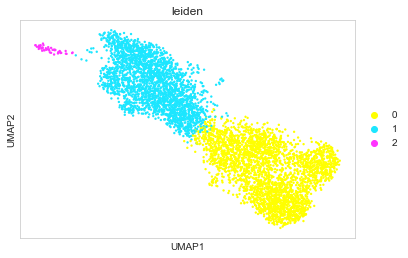

Trying to set attribute `.uns` of view, copying.


['PABPC1', 'CCL5', 'CCL4']

In [18]:
marker_genes = determine_marker_genes(adata, resolution=0.3, visualize=True)
marker_genes

# UMPAS

The following shows the UMAP visualization of the differen models. The UMAP parameter n_neighbors and min_distance are optimized visually per model.

In [19]:
def plot_umaps(adata, n_neighbors=15, min_dist=0.5, title=''):
    adata_tmp = adata.copy()
    sc.pp.neighbors(adata_tmp, n_neighbors=n_neighbors, random_state=42, use_rep='X')
    sc.tl.umap(adata_tmp, min_dist=min_dist, random_state=42)

    groups = ['T_cells', 'reactive_combined'] + marker_genes
    for col in groups:
        if col in marker_genes:
            sc.pl.umap(adata_tmp, color=col, title=title, color_map=sns.color_palette("viridis", as_cmap=True))
        else:
            sc.pl.umap(adata_tmp, color=col, title=title)

Subsample unreactive cells to same amount as reactive size for nicer UMAP visualization.

In [20]:
np.random.seed(42)

In [21]:
adata = sc.read_h5ad('../data/Covid/04_covid_highly_var_5000.h5ad')
adata = adata[adata.obs['set'] == 'train']

do_subsample = True
if do_subsample:
    reactive_states = ['CD4 reactive (unstimulated)', 
                       'CD8 reactive (unstimulated)', 
                       'CD8 reactive (stimulated)', 
                       'CD4 reactive (stimulated)']
    adata_reactive = adata[adata.obs['reactive_condition'].isin(reactive_states)]
    adata_unreactive = adata[~adata.obs['reactive_condition'].isin(reactive_states)]
    p = len(adata_reactive)/len(adata_unreactive)
    downsample_mask =  np.random.choice([True, False], size=len(adata_unreactive), replace=True, p=[p, 1-p])
    adata_unreactive = adata_unreactive[downsample_mask]
    adata_subsample = adata_reactive.concatenate([adata_unreactive])
else:
    adata_subsample = adata

In [22]:
latent_poe_balanced = get_latent('poe_balanced', adata_subsample)
latent_cc_balanced = get_latent('cc_balanced', adata_subsample)

latent_tcr = get_latent('TCR', adata_subsample)
latent_rna = get_latent('RNA', adata_subsample)

Add marker genes to adata object containing the latent space for visualization

In [23]:
latent_spaces = [
    latent_poe_balanced,
    latent_cc_balanced,
    latent_tcr,
    latent_rna
]

In [24]:
for gene in marker_genes:
    for latent in latent_spaces:
        latent.obs[gene] = adata_subsample.obs_vector(gene)

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


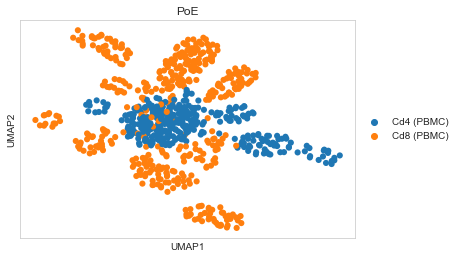

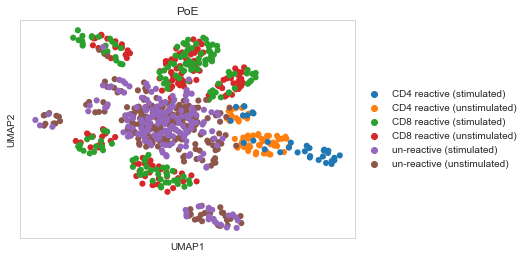

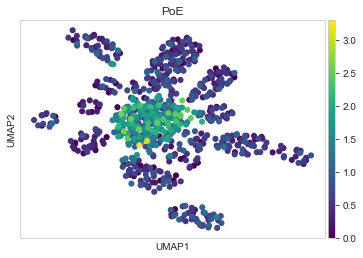

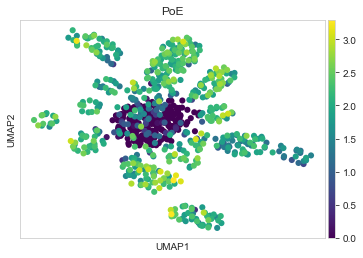

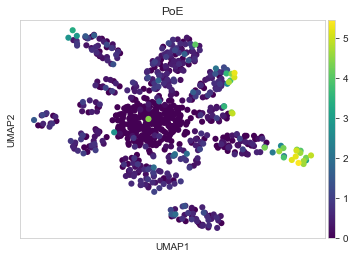

In [25]:
plot_umaps(latent_poe_balanced, n_neighbors=25, min_dist=2., title=f'PoE')

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


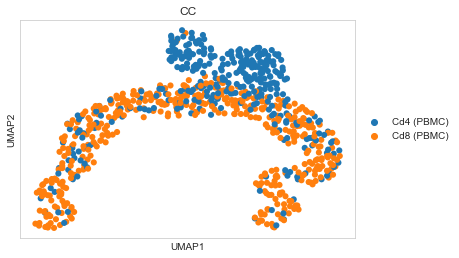

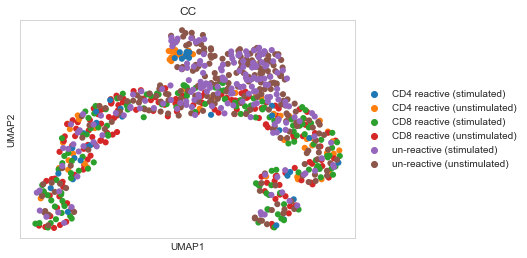

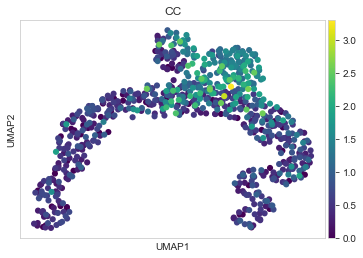

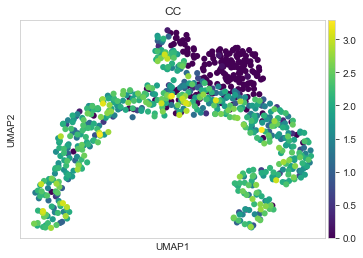

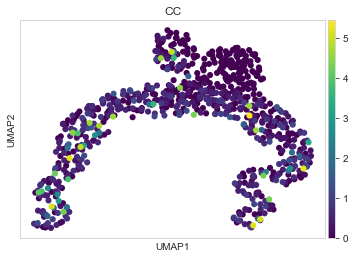

In [26]:
plot_umaps(latent_cc_balanced, n_neighbors=50, min_dist=2., title=f'CC')

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


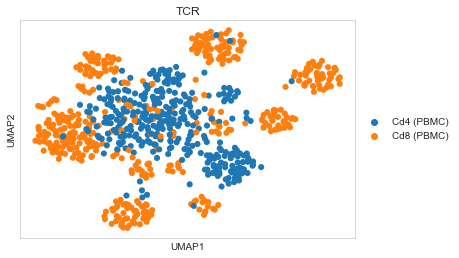

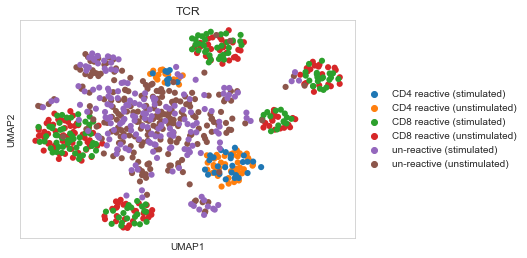

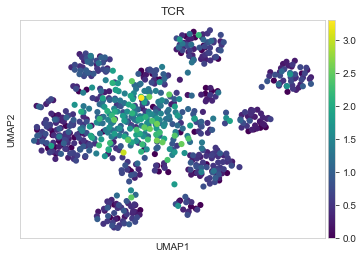

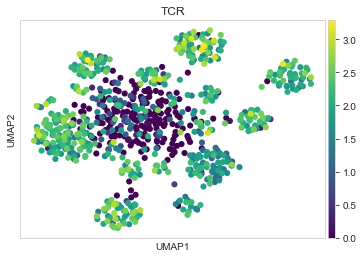

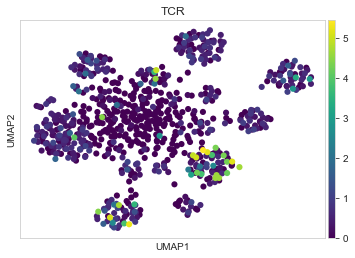

In [27]:
plot_umaps(latent_tcr, n_neighbors=25, min_dist=1., title=f'TCR')

... storing 'dataset' as categorical
... storing 'T_cells' as categorical
... storing 'reactive_combined' as categorical
... storing 'condition' as categorical


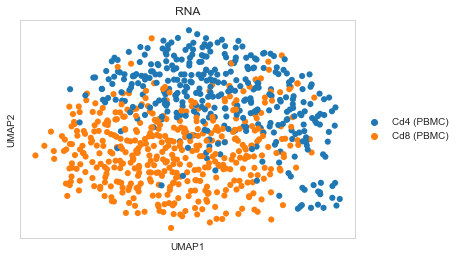

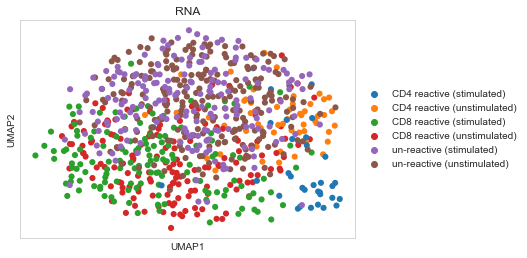

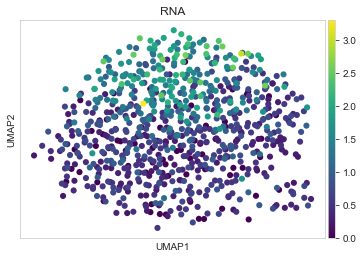

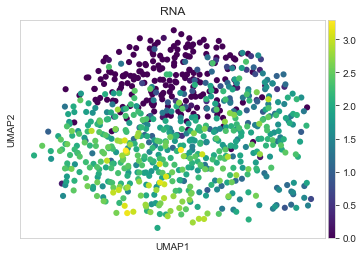

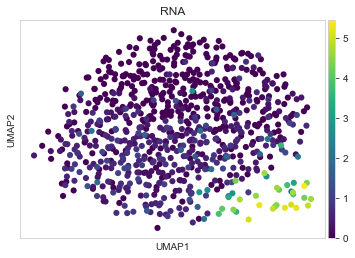

In [28]:
plot_umaps(latent_rna, n_neighbors=25, min_dist=1., title=f'RNA')